In [172]:
# using Pkg
# Pkg.activate("")

# # Packages that you need
# packages_to_install = ["MLDatasets", "Plots", "Statistics", "Distributions", "Random", "Flux", "Yao", "FLOYao", "PythonCall", "BenchmarkTools", "Dates", "FiniteDifferences"]

# for pkg in packages_to_install
#     Pkg.add(pkg)
# end

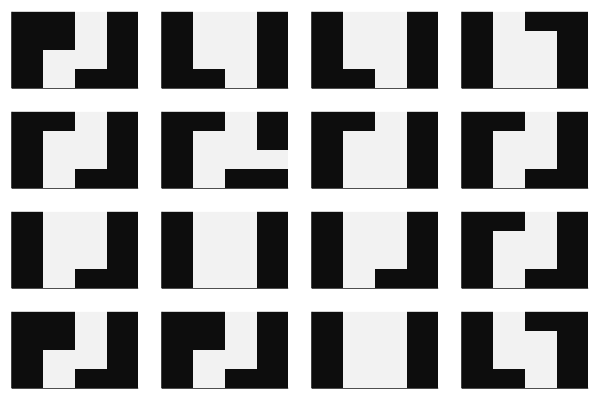

In [173]:
using MLDatasets
using Plots
using Statistics
using Distributions
using Random

train = 16 # Size of training dataset

digit = 1 # Digit to be learned
image_size = 28 # Size of image
compress_size = 4 # Size of compressed image

function compress(img, original, compress, max = true) #If max is false, then it does mean-convolution instead
    ratio = original ÷ compress
    compressed = zeros(compress, compress)
    a = []
    for i in 0:compress-1
        for j in 0:compress-1
            empty!(a)
            for p in 1:ratio
                for q in 1:ratio
                    push!(a, img[(ratio*i) + p, (ratio*j) + q])
                end
            end
            compressed[i+1, j+1] = max ? maximum(a) : mean(a)
        end
    end
    return compressed
end

train_set = MNIST(:train)
train_labels = MNIST(split=:train).targets

data_train = []
c = 1
trainstats = []
for _ in 1:train
    while train_labels[c] != digit
        c += 1
    end
    push!(data_train, compress(rotl90(train_set[c][1]), image_size, compress_size) .> 0.5)
    push!(trainstats, sum(compress(train_set[c][1], image_size, compress_size) .> 0.5))
    c += 1
end

plot([heatmap(x, color=:grays, colorbar = false, ticks = false) for x in data_train]...) #Is there any way to make this look nicer? use pythoncall and matplotlib i guess

In [174]:
using Yao
using Flux

N = compress_size^2 #Number of qubits

#Parameters are random (typically is N(0, sqrt(width)), not really sure how it's implemented)
d = Chain(Dense(N, 10, relu), Dense(10, 1, sigmoid)) 
# Use CNN (because it's currently very bad at distinguishing images)
# Writing a discriminator in Pytorch is better?

nparams = sum(length, Flux.params(d))
println("Number of parameters in discriminator: $nparams")

layers = 5
g = chain(N)
for _ in 1:layers
    for i in 1:N-1
        push!(g, rot(kron(N, i => X, i+1 => X), 0.)) #Implemented using qiskit's definition (https://qiskit.org/documentation/stubs/qiskit.circuit.library.RXXGate.html)
    end
    for i in 1:N-1
        push!(g, rot(kron(N, i => X, i+1 => Y), 0.))
    end
    # for i in 1:N-1
    #     push!(g, rot(kron(N, i => Y, i+1 => Y), 0.))
    # end
    # Not needed YY = XX and IZ and ZI
    for i in 1:N
        push!(g, put(N, i => Rz(0.)))
    end
end
#To enhance expressibility:
# Change circuit ansatz to include more generators
# Change pprior() to become nonconstant
# Gradient doesn't change if you sample from a nonconstant distribution of states? As opposed to all zero state
# Can prove this analytically
# Run on GPU?

nparams = nparameters(g)
println("Number of parameters in generator: $nparams")  
#dispatch!(g, :random)
dispatch!(g, rand(nparams).*2π)
println(parameters(g))

Number of parameters in discriminator: 181
Number of parameters in generator: 155
[2.790198254800068, 5.760384250968019, 2.439015241461342, 0.17841359412370128, 3.7085752964643737, 1.251247477751267, 3.9972597873728786, 2.8940504828336167, 4.942126724424185, 4.7340880140042465, 0.467329843098068, 1.890993969180748, 2.9905532478995895, 0.7536633323658912, 0.38719896974283313, 1.2230228156331997, 2.434479733961254, 1.9652082850035555, 2.18481063258842, 0.2176753824130544, 1.7087538447687358, 0.043479478554692724, 1.4914157340907004, 4.489797542621052, 0.9546253035038164, 4.030543030970732, 0.6135906477869622, 2.960164441588187, 3.2690556232047605, 1.854943377200584, 5.915215280304939, 0.09251782825742527, 6.01284082570911, 4.991260441352456, 4.323223399811648, 5.964988544162411, 1.423195599779453, 0.7866113184179058, 1.868777475230274, 4.793658813692609, 6.247274552086811, 4.17353922473123, 4.467648397972977, 0.8372670526171733, 1.1266345056751084, 5.104559206397789, 2.280854983653942, 1

μ: 6.5
σ: 0.9660917830792959
Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

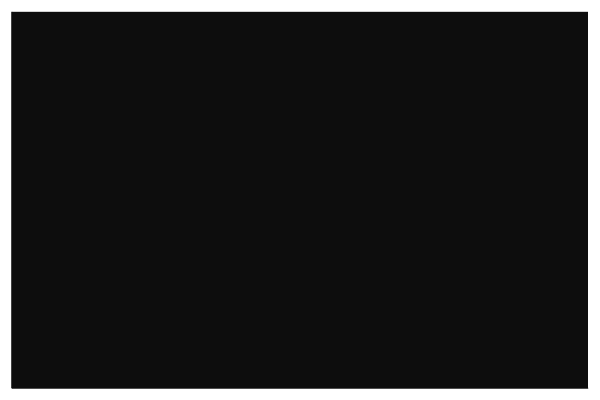

In [175]:
using FLOYao
using Random
using Distributions

mu = mean(trainstats)
sigma = std(trainstats)
println("μ: $mu")
println("σ: $sigma")
#dist = Normal(mu, sigma/20)
dist = Normal(mu, 1)

#ratio = rand(dist) / N
ratio = 0 #if ratio = 0 then pprior() is all 0s
function pprior() #For each square, probability ratio that it's white, where ratio ~ N(mean(data), std(data)) /  N; maybe we can vary pprior later?
    a = rand(N) .< ratio
    return FLOYao.product_state(Int.(a)) #Returns MajoranaReg; Prepares it to be sent through the generator 
end

pprior_example = rand(N) .< ratio
print(pprior_example)
heatmap(rotl90(reshape(pprior_example, compress_size, compress_size)) .> 0.5, color=:grays, colorbar = false, ticks = false)

In [176]:
using Flux: train!
using Yao
using FLOYao
using Statistics

function postprocess(g_output::Vector) #turns the output of reg |> g |> measure into an Int vector
    result = []
    for i in 1:N 
        push!(result, g_output[1][end - i + 1])
    end
    Int.(result)
end

samplemean_batch = 50 #This doesn't need to be that big
dispatch!(g, rand(nparams).*2π)
function run_g(; theta = parameters(g), nbatch = samplemean_batch)
    dispatch!(g, theta)
    samples = []
    for i in 1:nbatch
        z = pprior() #MajoranaReg object
        result = z |> g |> measure |> postprocess
        if i == 1
            samples = result
        else
            samples = hcat(samples, result) #is this operation slow; on another note there has to be a better way to write this function right
        end
    end
    samples
end
#outputs an N * #samples matrix

function run_d_fake(samples)
    if size(samples)[1] != N #Require samples to be an N x #samples matrix
        println("Improper formatting of samples")
        return
    end
    samples |> d
end

function run_d_real() #Runs d on all training data
    samples = []
    for i in 1:train
        result = data_train[i] |> vec
        if i == 1
            samples = result
        else
            samples = hcat(samples, result)
        end
    end
    samples |> d
end

function gLoss(; theta = parameters(g), nbatch = samplemean_batch)
    dispatch!(g, theta)
    -mean(log.(run_d_fake(run_g(theta, nbatch))))
end

#Ideally... but how do u get gradients to go down? do we just not use flux train? tbh i'm ok with that but then i need to figure out how else to implement optimization stuff (maybe use python)
# function dLoss(nbatch = samplemean_batch)
#     real = mean(log.(run_d_real()))
#     fake = mean(log.(1 .- run_d_fake(run_g(nbatch))))
#     -(real + fake)
# end

#This is only formatted like this in order to use Flux.train!
#So maybe I shouldn't use it?
function dLoss(m, real, fake) #m is the discriminator, real is the actual data, fake is G(z) where z is sampled from pprior()
    -(log.(m(real)) + log.(1 .- m(fake))) |> first
end

gLoss()

0.60366166f0

In [177]:
# using Plots
# using Statistics

# p = []
# for _ in 1:500
#     push!(p, gLoss())
# end

# histogram(p, bins=20, xlabel="gLoss", ylabel="Frequency")

# #@time gLoss() #It's still decently spread out...

In [178]:
using Yao
using FLOYao

function parametershift_grad(theta = parameters(g)) #Shift parameters in-place
    l = nparameters(g)
    temp_params = theta
    temp_params[1] += π/2
    grad = zeros(l)
    for i in 1:l
        plus = 0
        minus = 0
        dispatch!(g, temp_params)
        plus = gLoss() #This is the problem
        temp_params[i] -= π
        dispatch!(g, temp_params)
        minus = gLoss()
        grad[i] = (plus - minus) / 2
        if i < l
            temp_params[i] += π/2
            temp_params[i+1] += π/2
        end
    end
    temp_params[l] += π/2
    dispatch!(g, temp_params)
    grad
end

#println(finitediff_grad())
#Computing gradients is slow and also I'm still getting different results for parametershift and finitediff
#parametershift prints very small numbers and finitediff prints very big numbers...

# for _ in 1:10
#     println(parametershift_grad()) #Should print similar numbers...
# end

parametershift_grad (generic function with 2 methods)

In [179]:
g_lr = 1
d_lr = 0.5

opt_flag = 1
if opt_flag == 1
    d_opt = Flux.setup(Adam(), d) 
elseif opt_flag == 2
    d_opt = Flux.setup(Descent(d_lr), d) #lol is this right
elseif opt_flag == 3
    d_opt = Flux.setup(SGD(), d) #yeah idk anymore
end

gLoss_values = []
dLoss_values = []
g_epochs = 50
d_epochs = 10 
epochs = 10
batch = train

for i in 1:epochs
    t = time()
    for j in 1:g_epochs
        dispatch!(-, g, parametershift_grad() * g_lr)
        push!(gLoss_values, gLoss())
    end
    for j in 1:d_epochs
        real = []
        fake = []
        for m in 1:batch
            x = data_train[m] |> vec 
            push!(real, Int.(x))
            push!(fake, run_g(nbatch = 1))
        end
        data = collect(zip(real, fake)) 
        Flux.train!(dLoss, d, data, d_opt)
        s = 0
        for x in data
            s += dLoss(d, x[1], x[2])        
        end
        push!(dLoss_values, s / batch)
    end
    println("iteration $i done in: ", time() - t)
end

#last g_epochs of training for the generator, because we want g to be good, don't really care about d
for _ in 1:g_epochs
    dispatch!(-, g, parametershift_grad() * g_lr)
    push!(gLoss_values, gLoss())
end

iteration 1 done in: 11239.861453056335
iteration 2 done in: 

11158.812309980392


InterruptException: InterruptException:

Generator loss
Any[

0.5692859f0, 0.5360673f0, 0.49473408f0, 0.45735586f0, 0.41619316f0, 0.381501f0, 0.35046554f0, 0.32357633f0, 0.29677573f0, 0.28132868f0, 0.26708332f0, 0.25361192f0, 0.24247251f0, 0.23480073f0, 0.2278271f0, 0.22047053f0, 0.21908653f0, 0.21261474f0, 0.20913096f0, 0.20312843f0, 0.20080952f0, 0.19982448f0, 0.19658035f0, 0.19314593f0, 0.19276035f0, 0.18968044f0, 0.18726155f0, 0.18530776f0, 0.18344969f0, 0.18177746f0, 0.1799576f0, 0.1783792f0, 0.17850856f0, 0.17632759f0, 0.17670327f0, 0.17350127f0, 0.17411032f0, 0.1724089f0, 0.17090535f0, 0.17059557f0, 0.16922021f0, 0.16724122f0, 0.16698007f0, 0.1666795f0, 0.16608076f0, 0.16622098f0, 0.16534366f0, 0.16515884f0, 0.1637658f0, 0.16343507f0, 0.67568153f0, 0.650745f0, 0.6220376f0, 0.5999002f0, 0.57300925f0, 0.55799836f0, 0.5339757f0, 0.5145582f0, 0.5000603f0, 0.48347208f0, 0.46956807f0, 0.45639896f0, 0.44402948f0, 0.43347335f0, 0.4255244f0, 0.41429356f0, 0.4076445f0, 0.395331f0, 0.38619554f0, 0.37919852f0, 0.36943257f0, 0.35818154f0, 0.3490548f0, 

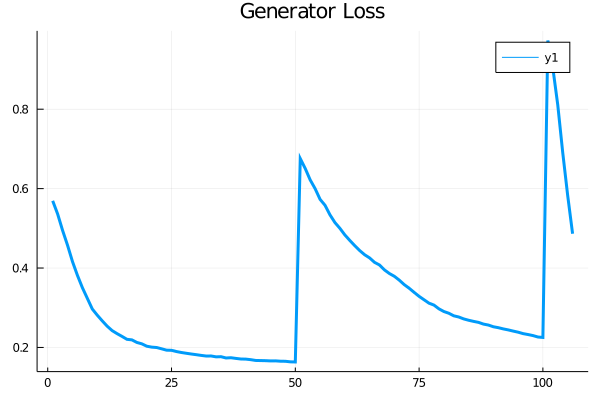

In [180]:
println("Generator loss")

println(gLoss_values)
# for l in gLoss_values
#     println(l)
# end

plot(gLoss_values, title = "Generator Loss", linewidth=3)

Discriminator loss
Any[2.008689f0, 1.8094743f0, 1.681123f0, 1.5795106f0, 1.4666095f0, 1.3580968f0, 1.2493484f0, 1.2525169f0, 1.1810571f0, 1.1020008f0, 1.7235866f0, 1.4410527f0, 1.3430904f0, 1.2659754f0, 1.1817181f0, 1.0620763f0, 1.0537155f0, 1.0175387f0, 0.97712266f0, 0.9006686f0]


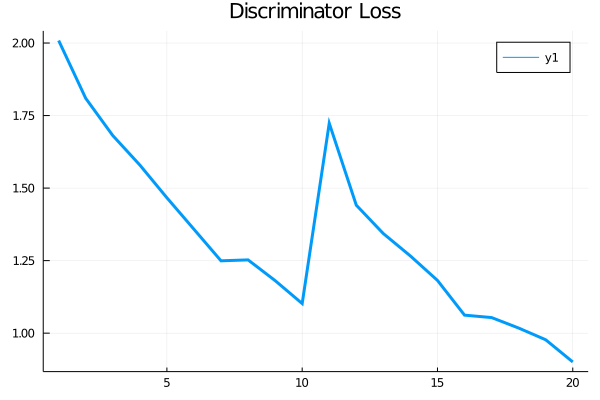

In [181]:
println("Discriminator loss")

println(dLoss_values)
# for l in dLoss_values
#     println(l)
# end

plot(dLoss_values, title = "Discriminator Loss", linewidth=3)

In [187]:
#Testing the Discriminator

d_fake = first(run_d_fake(run_g(nbatch = 1)))
println("fake data: $d_fake") #Should print a number close to 0

index = rand(1:train)
d_real = data_train[index] |> vec |> d |> first
println("real data: $d_real") #Should print a number close to 1

fake data: 0.7586918
real data: 0.72787565


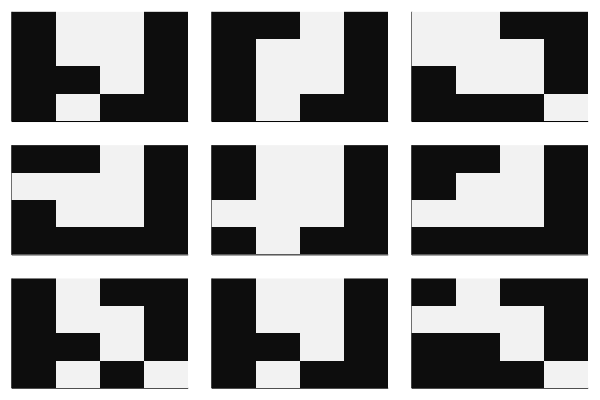

In [190]:
#Testing the Generator

nsamples = 9
samples = run_g(nbatch = nsamples)
plot([heatmap(reshape(samples[:, i], compress_size, compress_size), color=:grays, colorbar = false, ticks = false) for i in 1:nsamples]...)